In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
import torch
from torch.nn import Module, Sequential, Linear, ReLU, Tanh, Sigmoid
import torch.nn.functional as F
from tukey import losses
from tukey.transforms import SoftPlusTransform

## Definition of neural network 

In [5]:
class NN(Sequential):
    def __init__(self, structure: list, n_out: int):
        subblocks = []
        self.n_out = n_out
        for i in range(len(structure) - 1):
            subblocks.extend(self._make_sublock(structure[i], structure[i + 1]))
        subblocks.extend(self._make_final_layer(structure[-1]))
        t = SoftPlusTransform()
        t.indices=[1, ]
        subblocks.append(t)
        super().__init__(*subblocks)

    def _make_sublock(self, n_in: int, n_out: int):
        return [Linear(n_in, n_out), ReLU(), ]

    def _make_final_layer(self, n_in : int):
        return [Linear(n_in, self.n_out),]
        
    def forward(self, x: torch.Tensor):
        y = super().forward(x)
        #z = torch.zeros_like(y)
        #z[:, 0] = y[:, 0]
        #z[:, 1] = F.softplus(y[:, 1] - 5)
        #z[:, 2:] = y[:, 2:]
        return y

nn = NN((1, 256, 512, 1024), 4)
nn_gaussian = NN((1, 256, 512, 1024), 2)

## Definition of the true model and simulation 

For our simulation study, we consider a very simple regression problem of a scalar target $Y$ in terms of a scalar feature $X$. The true conditional distribution of $Y$ given $X$ is defined according to the following equation,

\begin{equation}
    Y | X \sim \mu(X) + \sigma(X) \tau_{g(X), h(X)}(Z),
\end{equation}
where the functions $\mu(\cdot)$, $\sigma(\cdot)$, $g(\cdot)$ and $h(\cdot)$ are defined arbitrarily --- see the functioon $f$ defined in the code portion below. The random variable $Z$ is standard normal, $Z\sim\mathcal{N}(0, 1)$, while $\tau_{g,h}$ is the tukey $g$ and $h$ transform.

For our simulations we sample $X$ according to a uniform distribution on the interval $[0, 1]$.

<IPython.core.display.Javascript object>


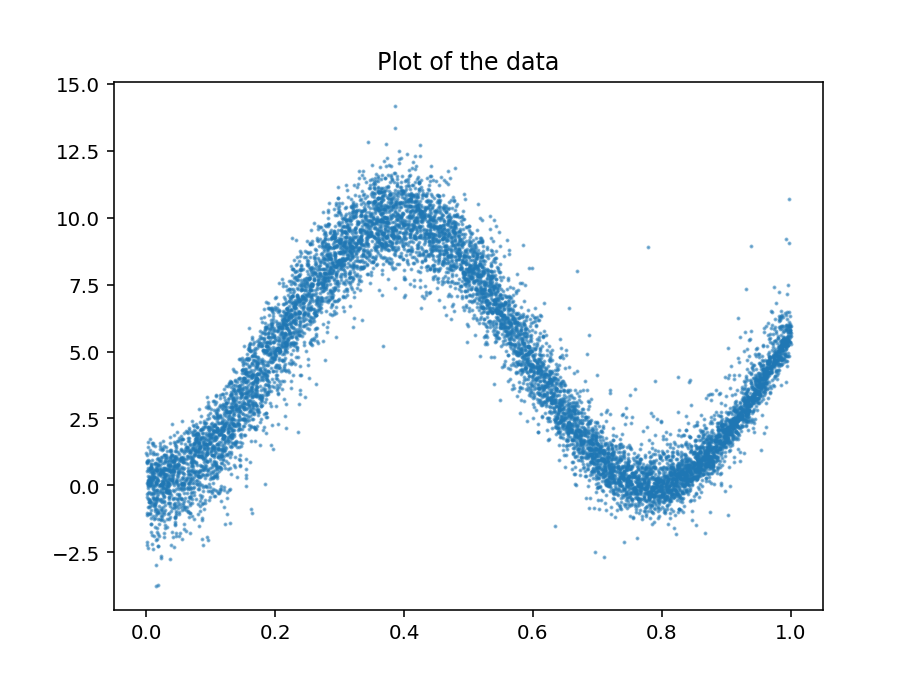

Text(0.5, 1.0, 'Plot of the data')

In [15]:
def f(x: float) -> tuple:
    """Function providing the 4 parameters of the transformation applied to 
    a standard normal variable given the input x."""
    return 10 * np.sin(4 * x) ** 2, 1 + 3 * (x - 0.25)**2, 1 / 2 * (x - 0.5), x**2 / 4

def tukey_g_h(z: float, theta: tuple):
    """Applies the tukey-g-h transform with parameters theta to z."""
    mu, beta, g, h = theta
    z_tilda = 1 / g * (np.exp(g * z) - 1) * np.exp(h * z**2 / 2)
    return mu + 1 / beta * z_tilda

def t_dist(x: float):
    return t(df = 3 * x + 3, loc = 4 * x**2, scale = 0.2 + (x - 0.5)**2).rvs(10000)

x_data = np.random.rand(10000).astype(np.float32)
z = np.random.randn(10000).astype(np.float32)
theta = f(x_data)
y_data = tukey_g_h(z, theta)

#y_data = t_dist(x_data)

%matplotlib notebook
import matplotlib as mpl
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(x_data, y_data, s=1, alpha=0.5)
ax.set_title('Plot of the data')

## Training 

For training, we consider two model

In [9]:
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, TensorDataset

BATCH_SIZE = 128
N_EPOCHS=25

loss = losses.TuckeyGandHloss(n_target_channels=1)
loss_gaussian = losses.GaussianLoss(n_target_channels=1)
nn_parameters = nn.parameters()
nn_gaussian_parameters = nn_gaussian.parameters()

x_torch, y_torch = torch.tensor(x_data).reshape((-1, 1)), torch.tensor(y_data).reshape((-1, 1))
dataset = TensorDataset(x_torch, y_torch)
optimizer = Adam(nn_parameters, lr=1e-4)
optimizer_gaussian = Adam(nn_gaussian_parameters, lr=1e-4)

In [10]:
nn.train()
nn_gaussian.train()

def train_for_one_epoch():
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    losses_gaussian = []
    for x, y in dataloader:
        optimizer.zero_grad()
        y_hat = nn(x)
        loss_y_yhat = loss(y_hat, y)
        loss_y_yhat.backward()
        optimizer.step()
        losses.append(loss_y_yhat.detach().item())
        # gaussian
        y_hat = nn_gaussian(x)
        loss_y_yhat = loss_gaussian(y_hat, y)
        loss_y_yhat.backward()
        optimizer_gaussian.step()
        losses_gaussian.append(loss_y_yhat.detach().item())
    return np.mean(losses), np.mean(losses_gaussian)



for i_epoch in range(N_EPOCHS):
    epoch_loss = train_for_one_epoch()
    print(epoch_loss)

(0.3322554317456258, 1.7072529973863046)
(0.3322104696608797, 2.297344056865837)
(0.3324915131058874, 1.5316870484171035)
(0.32300003797193116, 1.76604978796802)
(0.31485589159817634, 1.8852831230887883)
(0.31364008718276326, 1.279097643079637)
(0.3170018856283985, 1.3728837302968473)
(0.3189175222304803, 1.089296783073039)
(0.31523243139816237, 0.9816449963593785)
(0.3122175188758705, 0.986446803129172)
(0.3222597986459732, 0.975681799876539)
(0.30970946765398677, 0.9027230475522294)
(0.3088034280116045, 0.8527156031584437)
(0.3157782980912848, 0.863548578340796)
(0.31573626380177994, 0.8412505109098893)
(0.3154540224165856, 0.8423218123520477)
(0.3128075643053538, 0.8469956728476512)
(0.3242189680709492, 0.9004316661931291)
(0.3101919142034235, 0.8833308997033518)
(0.31173560777796977, 0.8818351815018473)
(0.314046611137028, 0.9508759107770799)
(0.30532485043889357, 1.0153191995017137)
(0.3128207671114161, 0.9156397415112846)
(0.317015579418291, 1.0560126795044429)
(0.313287388297575

## Analysis 

For analysis, we plot the 4 functions of $x$ that make up the true model (solid lines) and the values predicted by the neural network (dashed lines).

<IPython.core.display.Javascript object>


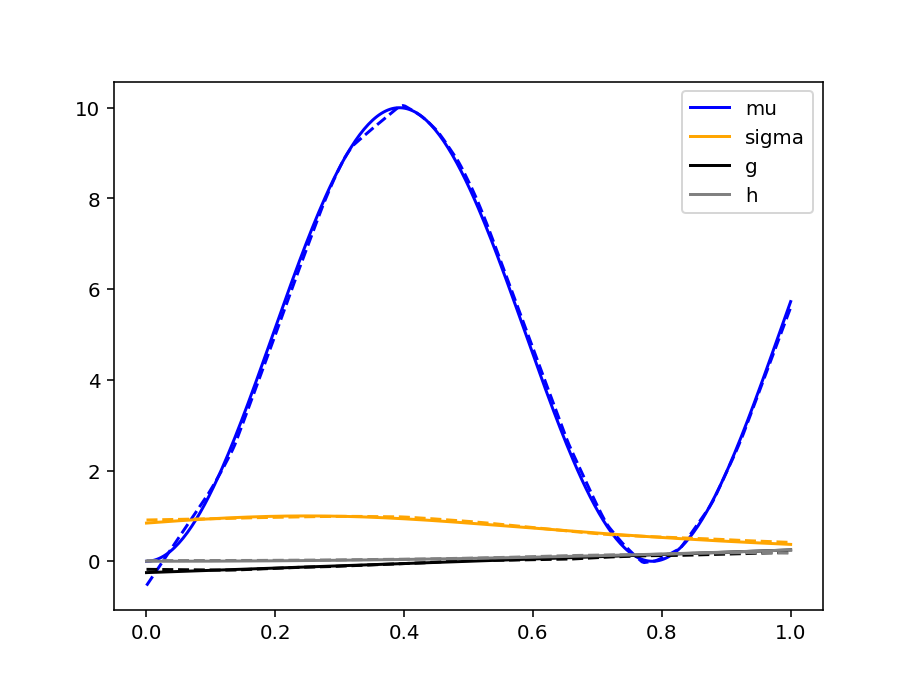

In [11]:
x_plot = np.linspace(min(x_data), max(x_data), 300).astype(np.float32)
# true regressed values
mu, beta, g, h = f(x_plot)

# predictes values
x_test = torch.tensor(x_plot).reshape((-1, 1))
dataset_test = TensorDataset(x_test)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE)
y_hat = []

nn.eval()

with torch.no_grad():
    for x_batch in dataloader_test:
        pred = nn(x_batch[0])
        pred = np.hstack(loss.predict(pred))
        y_hat.append(pred)
y_hat = np.vstack(y_hat)
mu_hat = y_hat[:, 0]
beta_hat = y_hat[:, 1]
g_hat = y_hat[:, 2]
h_hat = y_hat[:, 3]

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(x_plot, mu, color='blue', label='mu')
ax.plot(x_plot, mu_hat, color='blue', linestyle='--')

ax.plot(x_plot, 1 / beta, color='orange', label='sigma')
ax.plot(x_plot, 1 / beta_hat, color='orange', linestyle='--')

ax.plot(x_plot, g, color='k', label='g')
ax.plot(x_plot, g_hat, color='k', linestyle='--')

ax.plot(x_plot, h, color='gray', label='h')
ax.plot(x_plot, h_hat, color='gray', linestyle='--')

ax.legend()

We now plot the true conditional distributions for 4 values of the feature $x$ (blue), the G-and-H distribution predicted by the neural network for these same 4 values of the feature (orange), and the Gaussian distributions predicted by a separate neural network trained for that purpose using negative Gaussian likelihood for the loss function (green)

<IPython.core.display.Javascript object>


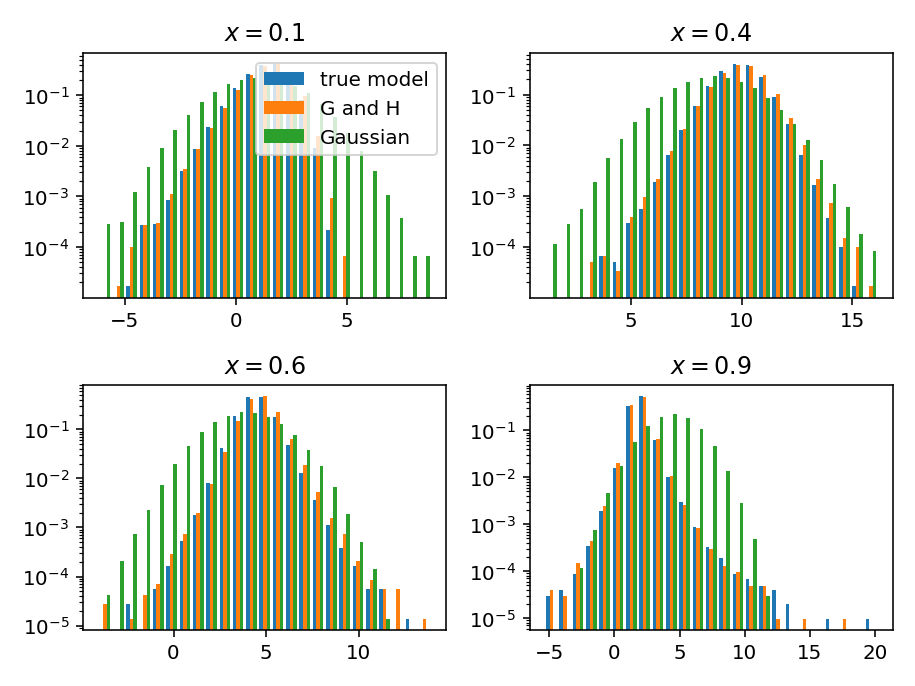

In [17]:
n_points = 100000
x_0s = [0.1, 0.4, 0.6, 0.9]
fig = plt.figure()


for i, x_0 in enumerate(x_0s):
    ax = fig.add_subplot(2, 2, i + 1)
    x = x_0 * np.ones(n_points, dtype=np.float32).reshape((-1, 1))
    z = np.random.randn(n_points).reshape((-1, 1))
    z2 = np.random.randn(n_points).reshape((-1, 1))


    theta_true = f(x)
    with torch.no_grad():
        theta_pred = loss.predict(nn(torch.tensor(x).reshape((-1, 1))))
        theta_gaussian_pred = loss_gaussian.predict(nn_gaussian(torch.tensor(x).reshape((-1, 1))))
    y_true = tukey_g_h(z, theta_true)
    #y_true = t_dist(x.reshape((1, -1))).reshape((-1, 1))

    y_pred = tukey_g_h(z, theta_pred)
    y_gaussian_pred = theta_gaussian_pred[0] + 1 / theta_gaussian_pred[1] * z

    ax.hist(np.hstack((y_true, y_pred, y_gaussian_pred)), bins=25, density=True, cumulative=False, log=True,
            label=('true model', 'G and H', 'Gaussian'))
    ax.set_title(f'$x={x_0}$')
    if i == 0:
        plt.legend()
fig.tight_layout()

For a more rigurous analysis, we can compare the distribution of the $\hat{z}_i$'s to that of a standard normal.

## Prediction confidence intervals 

One can easily obtain prediction confidence intervals from the trained neural network (even though these are not as rigurous as prediction confidence intervals understood in statistical terms, where one also accounts for the uncertainty in the parameter estimates - here this would correspond to the uncertainty in the parameters of the neural network, which could be approached by Bayesian NN or Bootstrapping??).

In [18]:
from scipy.stats import norm

confidence_level = 0.95

def get_std_normal_ci(level):
    left = norm.ppf((1 - level) / 2)
    right = - left
    return left, right

def get_tukey_ci(level, theta):
    left, right = get_std_normal_ci(level)
    return tukey_g_h(left, theta), tukey_g_h(right, theta)

torch.Size([100000, 1])